# Neural Style Transfer

- Based on https://www.tensorflow.org/tutorials/generative/style_transfer?hl=en
- Style transfer paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

## Importing the libraries

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
tf.__version__

'2.15.0'

## Loading the pre-trained convolutional neural network (VGG19)


In [ ]:
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
network.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
len(network.layers)

22

## Loading and pre-processing the images

### Content image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
content_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Images/chaves.jpeg')

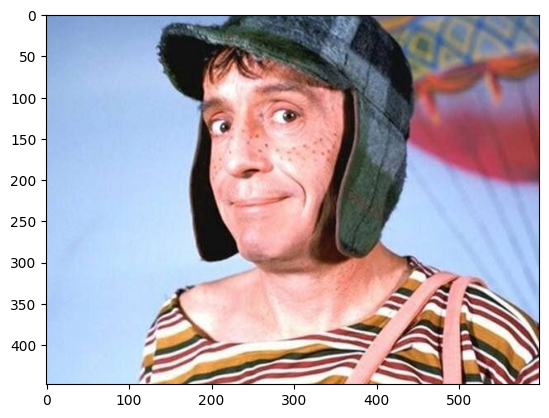

In [ ]:
plt.imshow(content_image);

In [ ]:
type(content_image)

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [ ]:
type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (448, 598, 3), 0.0, 255.0)

In [ ]:
content_image = content_image / 255

In [ ]:
content_image.min(), content_image.max()

(0.0, 1.0)

In [ ]:
content_image

array([[[0.47843137, 0.6039216 , 0.8039216 ],
        [0.47843137, 0.6039216 , 0.8039216 ],
        [0.47843137, 0.6039216 , 0.8039216 ],
        ...,
        [0.38039216, 0.45882353, 0.5529412 ],
        [0.38039216, 0.45882353, 0.5529412 ],
        [0.38039216, 0.45882353, 0.5529412 ]],

       [[0.4862745 , 0.6117647 , 0.8117647 ],
        [0.4862745 , 0.6117647 , 0.8117647 ],
        [0.4862745 , 0.6117647 , 0.8117647 ],
        ...,
        [0.3882353 , 0.46666667, 0.56078434],
        [0.3882353 , 0.46666667, 0.56078434],
        [0.3882353 , 0.46666667, 0.56078434]],

       [[0.49019608, 0.6156863 , 0.8156863 ],
        [0.49019608, 0.6156863 , 0.8156863 ],
        [0.49019608, 0.6156863 , 0.8156863 ],
        ...,
        [0.3882353 , 0.4745098 , 0.5686275 ],
        [0.3882353 , 0.4745098 , 0.5686275 ],
        [0.3882353 , 0.4745098 , 0.5686275 ]],

       ...,

       [[0.7294118 , 0.8627451 , 1.        ],
        [0.7254902 , 0.85882354, 1.        ],
        [0.7254902 , 0

In [ ]:
content_image = content_image[tf.newaxis, :]

In [ ]:
content_image.shape

(1, 448, 598, 3)

### Style image

In [ ]:
style_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Images/tarsila_amaral.jpg')

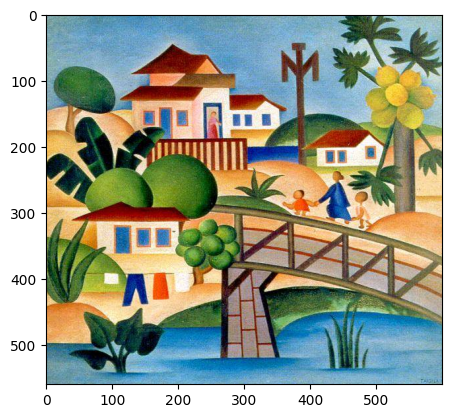

In [ ]:
plt.imshow(style_image);

In [ ]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]
style_image.shape

(1, 560, 600, 3)

In [ ]:
#style_image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Images/vangogh.jpg')

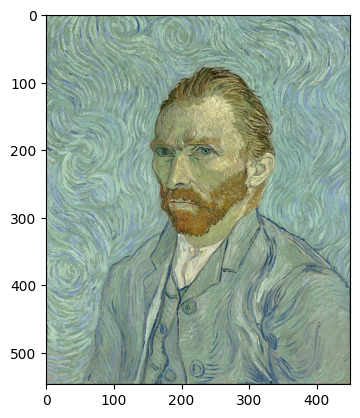

In [ ]:
#plt.imshow(style_image);

In [ ]:
#style_image = tf.keras.preprocessing.image.img_to_array(style_image)
#style_image = style_image / 255
#style_image = style_image[tf.newaxis, :]
#style_image.shape

(1, 547, 450, 3)

## Building the neural network

In [ ]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [ ]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, num_style_layers)

1 5


In [ ]:
[network.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  network = tf.keras.Model(inputs = [vgg.input], outputs = outputs)

  return network

In [ ]:
style_extractor = vgg_layers(style_layers)

In [ ]:
style_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
style_outputs = style_extractor(style_image)

In [ ]:
len(style_outputs)

5

In [ ]:
style_outputs[1]

<tf.Tensor: shape=(1, 280, 300, 128), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          7.14509821e+00, 0.00000000e+00, 1.24583855e+01],
         [0.00000000e+00, 0.00000000e+00, 1.67809772e+00, ...,
          2.64144611e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.14160025e+00, ...,
          5.38575315e+00, 0.00000000e+00, 1.16494739e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 1.79717135e+00, ...,
          5.83143663e+00, 0.00000000e+00, 1.26750255e+00],
         [0.00000000e+00, 0.00000000e+00, 2.02074122e+00, ...,
          6.57488346e+00, 0.00000000e+00, 2.64611077e+00],
         [0.00000000e+00, 0.00000000e+00, 7.94730473e+00, ...,
          1.31432257e+01, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.99022102e+00, 0.00000000e+00, ...,
          7.31287098e+00, 5.76284468e-01, 1.33476477e+01],
         [0.00000000e+00, 5.05766487e+00, 7.94253722e-02, ...,
       

In [ ]:
style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape

(TensorShape([1, 560, 600, 64]),
 TensorShape([1, 280, 300, 128]),
 TensorShape([1, 140, 150, 256]),
 TensorShape([1, 70, 75, 512]),
 TensorShape([1, 35, 37, 512]))

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/einsum

# Loss between the style and the content image (see original paper, section 2.2)
def gram_matrix(layer_activation):
  result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
  input_shape = tf.shape(layer_activation)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result / num_locations

In [ ]:
style_outputs[0]

<tf.Tensor: shape=(1, 560, 600, 64), dtype=float32, numpy=
array([[[[0.0000000e+00, 1.0877684e-01, 6.1876804e-02, ...,
          4.7548777e-01, 4.9462211e-01, 1.5644577e-01],
         [0.0000000e+00, 2.0908591e-01, 3.7850654e-01, ...,
          1.7786789e-01, 1.4868840e+00, 1.1423519e+00],
         [0.0000000e+00, 2.0027554e-01, 3.8594386e-01, ...,
          1.3720292e-01, 1.5296973e+00, 1.1784816e+00],
         ...,
         [0.0000000e+00, 3.3374473e-01, 5.1606625e-01, ...,
          0.0000000e+00, 1.6996144e+00, 1.3344206e+00],
         [0.0000000e+00, 3.4465256e-01, 5.2247041e-01, ...,
          0.0000000e+00, 1.7055957e+00, 1.3397942e+00],
         [7.8262198e-01, 4.2381793e-01, 7.7576435e-01, ...,
          4.4776672e-01, 2.4687252e+00, 2.3798752e+00]],

        [[0.0000000e+00, 1.1056373e-01, 0.0000000e+00, ...,
          8.2489133e-02, 0.0000000e+00, 0.0000000e+00],
         [6.3421273e-01, 2.3642045e-01, 3.5782573e-01, ...,
          0.0000000e+00, 5.8060557e-01, 7.0158607e-01

In [ ]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.63098735, 0.28931642, 0.2851602 , ..., 0.10537568,
         0.369587  , 0.45012608],
        [0.28931642, 0.24121156, 0.18381073, ..., 0.03157694,
         0.19594139, 0.21715762],
        [0.2851602 , 0.18381073, 0.16743274, ..., 0.02779872,
         0.19410352, 0.22709455],
        ...,
        [0.10537568, 0.03157694, 0.02779872, ..., 0.08297461,
         0.06948002, 0.06642947],
        [0.369587  , 0.19594139, 0.19410352, ..., 0.06948002,
         0.28682625, 0.3185408 ],
        [0.45012608, 0.21715762, 0.22709455, ..., 0.06642947,
         0.3185408 , 0.37468514]]], dtype=float32)>

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    # 0 - 1
    # -127.50 - 127.50
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
style_layers, content_layers

(['block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1'],
 ['block4_conv2'])

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
results = extractor(content_image)

In [ ]:
results

{'content': {'block4_conv2': <tf.Tensor: shape=(1, 56, 74, 512), dtype=float32, numpy=
  array([[[[  17.334454,    0.      ,    0.      , ...,  574.6942  ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  291.73843 ,
             132.49086 ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,  333.4564  ,
             117.71977 ,    0.      ],
           ...,
           [ 692.7537  ,    0.      ,    0.      , ..., 1512.0809  ,
              10.164044,  321.6707  ],
           [ 139.49521 ,    0.      ,    0.      , ..., 1108.5735  ,
             102.29359 ,  179.42448 ],
           [ 152.06628 ,    0.      ,    0.      , ...,  471.31976 ,
             179.42262 ,  671.04736 ]],
  
          [[   0.      ,    0.      ,    0.      , ...,  548.79626 ,
               0.      ,    0.      ],
           [   0.      ,    0.      ,    0.      , ...,   43.4741  ,
               0.      ,    0.      ],
           [   0.      ,    0

In [ ]:
for key, value in results.items():
  print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
len(style_targets), len(content_targets)

(5, 1)

In [ ]:
new_image = tf.Variable(content_image)

In [ ]:
content_weight = 1
style_weight = 100

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

## Training

In [ ]:
expected_output = np.array([10000, 15000])
predictions = np.array([8000, 15900])

In [ ]:
np.sum(abs(expected_output - predictions)) / 2

1450.0

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
mean_absolute_error(expected_output, predictions)

1450.0

In [ ]:
mean_squared_error(expected_output, predictions)

2405000.0

In [ ]:
2 ** 3, 2 * 2 * 2

(8, 8)

In [ ]:
10 ** 2, 10 * 10

(100, 100)

In [ ]:
((expected_output - predictions) ** 2).mean()

2405000.0

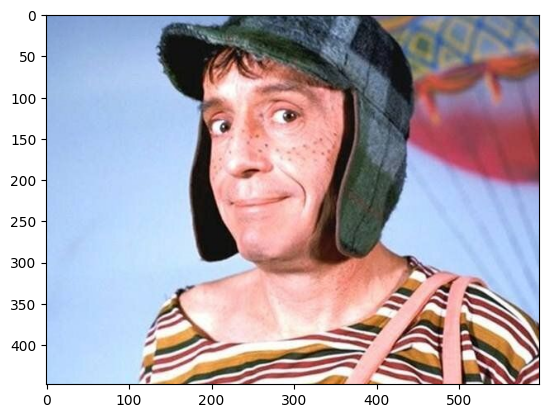

In [ ]:
plt.imshow(tf.squeeze(content_image, axis = 0));

In [ ]:
epochs = 3000
print_every = 500

for epoch in range(epochs):
  with tf.GradientTape() as tape:
    outputs = extractor(new_image)

    content_outputs = outputs['content']
    style_outputs = outputs['style']

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

    total_loss = content_loss * content_weight / num_content_layers + style_loss * style_weight / num_style_layers

  gradient = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(gradient, new_image)])

  new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

  if (epoch + 1) % print_every == 0:
    print('Epoch {} | content loss: {} | style loss: {} | total loss {}'.format(epoch + 1, content_loss, style_loss, total_loss))
    plt.imshow(tf.squeeze(new_image, axis = 0))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Visualizing the results

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
ax1.imshow(tf.squeeze(content_image, axis = 0))
ax1.set_title('Content image')
ax2.imshow(tf.squeeze(new_image, axis = 0))
ax2.set_title('New image')
ax3.imshow(tf.squeeze(style_image, axis = 0))
ax3.set_title('Style image')
plt.axis('off');

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
ax1.imshow(tf.squeeze(content_image, axis = 0))
ax1.set_title('Content/original image')
ax2.imshow(tf.squeeze(new_image, axis = 0))
ax2.set_title('New image')
ax3.imshow(tf.squeeze(style_image, axis = 0))
ax3.set_title('Style imagem')
plt.axis('off');